In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Loading relevant packages for loading data and performing analysis:

In [2]:
import os
import numpy as np
import glob
from IPython.utils import io
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, RepeatVector, Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from numpy import save, load
from pickleshare import PickleShareDB
import matplotlib.pyplot as plt
import gc
from plot_keras_history import plot_history

Checking the current working directory and setting it to the appropriate location:

In [3]:
os.getcwd()
os.chdir('C:\\Users\\Wyatt\\Documents\\Assignment4')
os.getcwd()

'C:\\Users\\Wyatt\\Downloads'

'C:\\Users\\Wyatt\\Documents\\Assignment4'

Loading the data from data prep stored in the pickled file:

In [4]:
db=PickleShareDB('movies/assign4.pshare')   # Use your own data, here.
db.keys()

['emMat10000X100',
 'wordIndx',
 'X_Test',
 'X_Train',
 'X_Val',
 'y_Test',
 'y_Train',
 'y_Val']

Assigning values to X from the db.keys() and checking shape. maxLen is set to 80 so we should see a our train,val,split of 20/40/40 here:

In [5]:
X_Train=db['X_Train']
X_Val=db['X_Val']
X_Test=db['X_Test']
print("X_Train shape is:", X_Train.shape)
print("X_Val shape is:",X_Val.shape)
print("X_Test shape is:",X_Test.shape)

X_Train shape is: (2000, 80)
X_Val shape is: (6000, 80)
X_Test shape is: (6000, 80)


Setting hyperparameters:

In [6]:
maxLen=80 # max review length, input length
maxWords=10000 # max number of words
batch_size=32 
emDim=100 #output dimension

In [7]:
from tensorflow.keras.backend import clear_session
clear_session()

In [28]:
gc.collect()

20

## Specifying an autoencoder:

Developing an encoder/decoder:

In [65]:
inputPadded=Input(shape=(maxLen,)) #creating adjusted input based on maxlen hyperparameter
embedLayer=Embedding(maxWords,output_dim=emDim,input_length=maxLen) #embedding layer converting indexes into layers, maxword input dimension, emDim output dimension, input length based on maxLen
x = embedLayer(inputPadded) # creating embeddings for inputPadded for use in model
state_hidden=Bidirectional(LSTM(32))(x) #setting the bidirectional LSTM with 32 units and applying to X
state_hidden=LeakyReLU(alpha=.3)(state_hidden) #leakyrelu activation
encodeM=Model(inputs=inputPadded,outputs=state_hidden) #creating the encoder model with inputs based on our padded input, and outputs determined by the above LSTM architecture

decoderOut=encodeM(inputPadded) #encoder for inputpadded

In [66]:
decoded=RepeatVector(maxLen)(decoderOut) #repeat vector to repeat input based on the max review length applied to the encoded variable
dec_lstm=Bidirectional(LSTM(32,return_sequences=True)) #Bidirectional LSTM with same number of units as in the encoder, 
decoded_lstm_output=dec_lstm(decoded) #applying above architecture to decoded object that created an input for the encodings
dec_dense=Dense(maxWords,activation='softmax') # dense layer added to model with softmax activation
decoder_outputs=dec_dense(decoded_lstm_output) #decoder for encoded inputpadded

In [67]:
autoEnc_Model=Model(inputPadded,decoder_outputs) #full autoencoder model with inputPadded as the X and decoder_outputs as the Y

In [68]:
autoEnc_Model.summary() #displaying a summary of the autoencoder model

Model: "functional_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
functional_20 (Functional)   (None, 64)                1034048   
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 80, 64)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 80, 128)           66048     
_________________________________________________________________
dense_4 (Dense)              (None, 80, 10000)         1290000   
Total params: 2,390,096
Trainable params: 2,390,096
Non-trainable params: 0
_________________________________________________________________


In [69]:
autoEnc_Model.compile(optimizer=Nadam(lr=0.00005),
                      loss='sparse_categorical_crossentropy'
                     ) #compliling the model with nadam optimizer, highest probability word output makes sparse categorical crossentropy appropriate, smaller learning rate to avoid overfitting

In [70]:
# early stopping used to prevent/minimize overfitting

from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(monitor='val_loss',patience=3)

In [71]:
# applying the model to the X_Train data with 30 epochs and X_Val as validation data and saving the model to history

history=autoEnc_Model.fit(X_Train,np.expand_dims(X_Train,-1),
                         batch_size=batch_size,
                         epochs=30,
                         validation_data=(X_Val,X_Val),
                         verbose=0,
                         callbacks=[callback])

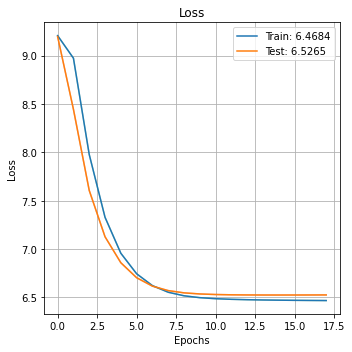

In [72]:
plot_history(history.history) #plotting the model loss for train/validate

In [73]:
X_TrainEm=encodeM.predict(X_Train) #using the model to create embeddings for X_Train
X_TrainEm.shape

(2000, 64)

In [74]:
X_ValEm=encodeM.predict(X_Val) #using the model to create embeddings for X_Val
X_ValEm.shape

(6000, 64)

In [75]:
X_TestEm=encodeM.predict(X_Test) #using the model to create embeddings for X_Test
X_TestEm.shape #checking shape to confirm it is in the same format and split

(6000, 64)

In [76]:
X_TestEm[0,:]

array([-0.1883505 , -0.20110784, -0.21114685,  0.6963701 ,  0.57733625,
        0.57845664, -0.17296433,  0.7566511 ,  0.73038644,  0.7117784 ,
        0.70593905, -0.2110039 , -0.19654368,  0.683468  , -0.20421082,
       -0.19898029, -0.21342508,  0.69585526, -0.21644811,  0.77591705,
        0.6867247 ,  0.71341723,  0.8261792 ,  0.7489408 ,  0.64903283,
        0.6590154 ,  0.5723735 , -0.22798118,  0.6605057 ,  0.74677813,
        0.7081963 ,  0.784872  ,  0.68197423,  0.7854637 ,  0.7352514 ,
        0.8458478 , -0.18257909, -0.22341077,  0.6364295 ,  0.8048006 ,
       -0.17997609, -0.21726088, -0.22082514, -0.22575255, -0.20343404,
       -0.22625902,  0.82916796, -0.22398676,  0.70356494, -0.22551993,
        0.80748713,  0.7538489 , -0.22232126,  0.74397075,  0.7194304 ,
       -0.2159073 , -0.23521443, -0.23763892, -0.22169413,  0.8313822 ,
       -0.18987346,  0.66969585,  0.7954426 ,  0.794398  ], dtype=float32)

Saving the embeddings for later use:

In [88]:
os.chdir('C:\\Users\\Wyatt\\Documents\\Assignment4')

In [89]:
movieDir = 'movies\\'
db4b= PickleShareDB(movieDir+'/assign4BB.pshare')
db4b.clear()

In [90]:
db4b['X_TrainEm']=X_TrainEm
db4b['X_ValEm']=X_ValEm
db4b['X_TestEm']=X_TestEm

In [91]:
db4b.keys()

['X_TestEm', 'X_TrainEm', 'X_ValEm']